<a href="https://colab.research.google.com/github/raplima/2020_cores_auto/blob/master/scripts/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone repository
!git clone https://github.com/raplima/2020_cores_auto.git

Cloning into '2020_cores_auto'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 408 (delta 62), reused 78 (delta 18), pack-reused 271
Receiving objects: 100% (408/408), 56.18 MiB | 11.65 MiB/s, done.
Resolving deltas: 100% (208/208), done.


In [1]:
import os

import json
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# count the instances
data_dir = '/content/2020_cores_auto/data'
folds_jsons = sorted(ii for ii in os.listdir(data_dir) if 'fold' in ii)

print(f'{"fold":8s} {"dset":9} {" #figures":10s} {" #instances":16s}')
for ii in folds_jsons:
    # read the metrics json file
    json_file = os.path.join(data_dir, ii)
    with open(json_file) as f:
        folds_dict = json.load(f)
    instances_in = sum(len(folds_dict[k]['regions']) for k in folds_dict.keys())
    fold = ii.split("_")[2]
    dset = ii.split("_")[3].split('.')[0]
    print(f'{fold:8s} {dset:8s} {len(folds_dict):10d} {instances_in:12}')


fold     dset       #figures   #instances     
0        train            56          543
0        val              15          113
1        train            57          493
1        val              14          163
2        train            57          551
2        val              14          105
3        train            57          543
3        val              14          113
4        train            57          494
4        val              14          162


In [3]:
# list the folders
#results_dir = '/content/2020_cores_auto/data/results/R50-C4'
#out_folders = sorted(os.listdir(results_dir))

results_root = '/content/2020_cores_auto/data/results/'

dfs = {}
for dir in os.listdir(results_root):
    results_dir = os.path.join(results_root, dir)
    out_folders = sorted(os.listdir(results_dir))

    # create dataframe
    metrics = []
    for dd in out_folders:
        fold = dd.split('_')[-1]
        # read the metrics json file
        json_file = os.path.join(results_dir, dd, 'metrics.json')
        with open(json_file) as f:
            for line in f:
                metrics.append(json.loads(line)) 
                metrics[-1]['fold'] = fold
                # clean up cores_fold_{fold}_train/ and cores_fold_{fold}_val/
                keys_to_clean = [k for k in metrics[-1] if 'cores_fold' in k]
                for k in keys_to_clean:
                    new_key = k.split('_', -1)[-1]
                    metrics[-1][new_key] = metrics[-1].pop(k)
    df = pd.DataFrame(metrics)                

    dfs[dir] = df.copy()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


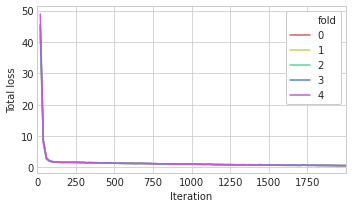

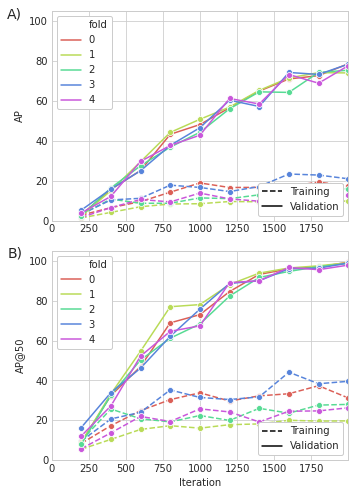

In [5]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

with plt.style.context('seaborn-whitegrid'):
    rcParams['font.sans-serif'] = ['Tahoma']
    rcParams['legend.framealpha'] = 1.0
    rcParams['legend.frameon'] = True
    palette = sns.color_palette("hls", len(df['fold'].unique()))
    
    # first fig
    fig, ax = plt.subplots(ncols=2, figsize=(5,6))
    sns.lineplot(x="iteration", y="total_loss", hue='fold', palette=palette, 
                 data=dfs['R50-C4'], ax=ax[0])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total loss')
    ax.set_xlim(0,np.max(df['iteration']))

    fig.tight_layout()
    fig.savefig('/content/training_loss.pdf')

    # second fig
    fig, ax = plt.subplots(2, figsize=(5,7))
    sns.lineplot(x="iteration", y="val/segm/AP", hue='fold', 
                 marker='o', palette=palette,
                 data=df, ax=ax[0])  

    sns.lineplot(x="iteration", y="val/segm/AP50", hue='fold', 
                 marker='o', palette=palette,
                 data=df, ax=ax[1])
    
    # change the dashes:
    [ax[0].lines[ii].set_linestyle("--") for ii, _ in enumerate(ax[0].lines)]    
    [ax[1].lines[ii].set_linestyle("--") for ii, _ in enumerate(ax[1].lines)]        

    sns.lineplot(x="iteration", y="train/segm/AP", hue='fold', 
                 marker='o', palette=palette, legend=False, 
                 data=df, ax=ax[0])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('AP')
    ax[0].set_xlim(0,np.max(df['iteration']))    
    ax[0].set_ylim(0,105) 

    sns.lineplot(x="iteration", y="train/segm/AP50", hue='fold', 
                 marker='o', palette=palette, legend=False,
                 data=df, ax=ax[1])
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('AP@50')
    ax[1].set_xlim(0,np.max(df['iteration'])) 
    ax[1].set_ylim(0,105) 

    # get the legend for the plotted lines.
    first_legends = [ax[ii].get_legend() for ii in range(len(ax))]
    # Add the legend manually to the current Axes.
    for ii, first_legend in enumerate(first_legends): 
        ax[ii].add_artist(first_legend)

    # set training/validation legend
    custom_lines = [Line2D([0], [0], color='k', ls="--"),
            Line2D([0], [0], color='k', ls="-")]
    for ii in range(len(ax)): 
        ax[ii].legend(custom_lines, ['Training', 'Validation'], loc='lower right') 

    # add letters:
    for ii, l in enumerate(['A)', 'B)']):
        ax[ii].text(-300, 100,
                    s=l, 
                    bbox=dict(facecolor='white', edgecolor='white', alpha=1), 
                    ha='left', va='bottom', size=14)
    
    fig.tight_layout()
    fig.savefig('/content/training_aps.pdf')


In [6]:
# create dataframe
metrics = []
for dd in out_folders:
    fold = dd.split('_')[-1]
    for dset in ['train', 'val']:
        # read the metrics json file
        json_file = os.path.join(results_dir, dd, f'cocoeval_{dset}_{fold}.json')
        with open(json_file) as f:
            metrics.append(json.load(f)['segm']) 
        metrics[-1]['fold'] = fold
        metrics[-1]['set'] = dset
df = pd.DataFrame(metrics)      
df = df.drop(labels=['APs', 'APm', 'APl'], axis=1)      

In [ ]:
df.groupby('set').describe()[['AP', 'AP75', 'AP50']].T

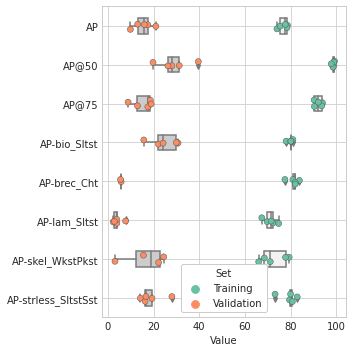

In [8]:
# "Melt" the dataset to "long-form" or "tidy" representation
melted = pd.melt(df, ["set", "fold"])
melted = melted.replace('AP50', 'AP@50')
melted = melted.replace('AP75', 'AP@75')

with plt.style.context('seaborn-whitegrid'):    
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Tahoma']
    rcParams['legend.framealpha'] = 1.0
    rcParams['legend.frameon'] = True
    # first fig
    fig, ax = plt.subplots(1, figsize=(5,5))

    sns.boxplot(x="value", y="variable", hue="set",
                dodge=False, width=0.4,
                data=melted,
                color=".8", ax=ax)

    # Show each observation with a scatterplot
    sns.stripplot(x="value", y="variable", hue="set", 
                  linewidth=0.5, size=6, palette="Set2",
                  data=melted, dodge=False, ax=ax)
    
    # Improve the legend 
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[-2:], labels=['Training', 'Validation'], 
              title="Set")
    ax.set_xlabel('Value')
    ax.set_ylabel('')
    ax.grid(True)

    fig.tight_layout()
    fig.savefig('/content/aps.pdf')